# TreeCorr Tutorial

Following tutorial:
https://rmjarvis.github.io/TreeCorr/_build/html/guide.html

Here I follow Maria's notebook on how to run xpipe.
https://cdcvs.fnal.gov/redmine/projects/des-clusters/wiki/XpipeTutorial

In [1]:
import numpy as np
import h5py
import healpy as hp
import matplotlib.pyplot as plt
from astropy.table import Table
import seaborn as sns
sns.set_context('talk')

## Read The Data

In [4]:
path = '/project/projectdirs/des/www/y3_cats/'
rm_fname = path+'y3_gold_2.2.1_wide_sofcol_run_redmapper_v0.5.1_redmagic_12_3_19.h5'

In [5]:
print('Taking a look at data structure')
rm = h5py.File(rm_fname,'r+')
print('all:',list(rm.keys()))
cat = rm['catalog/redmapper/lgt5']
ran = rm['randoms/redmapper/lgt5']
print('redMaPPer columns:',list(cat.keys()))
print()
print('random columns: ',list(ran.keys()))
rm.close()

Taking a look at data structure
all: ['catalog', 'index', 'masks', 'randoms', 'regions']
redMaPPer columns: ['bcg_ilum', 'bcg_spec_z', 'c_lambda', 'c_lambda_err', 'chisq', 'dec', 'dec_cent', 'dec_orig', 'dlambda_dz', 'dlambda_dz2', 'dlambdavar_dz', 'dlambdavar_dz2', 'ebv_mean', 'geomaskfrac', 'id_cent', 'ilum', 'lambda_chisq', 'lambda_chisq_c', 'lambda_chisq_ce', 'lambda_chisq_cent', 'lambda_chisq_e', 'lambda_zred', 'lambda_zred_e', 'lim_exptime', 'lim_limmag', 'lim_limmag_dered', 'lim_limmag_hard', 'lnbcglike', 'lnlamlike', 'lnlike', 'mag_lambda_err', 'maskfrac', 'maskgal_index', 'mem_match_id', 'members', 'model_mag', 'model_magerr', 'ncent', 'ncent_good', 'ncross', 'p_bcg', 'p_c', 'p_cen', 'p_fg', 'p_sat', 'pz', 'pzbins', 'q_cen', 'q_miss', 'r_lambda', 'ra', 'ra_cent', 'ra_orig', 'refmag', 'refmag_err', 'rmask', 'scaleval', 'w', 'z', 'z_init', 'z_lambda', 'z_lambda_e', 'z_lambda_e_raw', 'z_lambda_niter', 'z_lambda_raw', 'z_spec_init', 'zlambda_cent', 'zred', 'zred_chisq', 'zred_e']


In [6]:
def read_hdf5(fname, path, columns=None):
    """Read the hdf5 files for a given path
    if columns is None read all columns
    """
    h5  = h5py.File(fname,'r+')
    h5group = h5[path]
    if columns is None: columns = list(h5group.keys())
    
    out = dict()
    for col in columns:
        out[col] = h5group[col][:]
    
    return out

In [7]:
columns = ['mem_match_id','ra','dec','z_lambda','lambda_chisq']
rm = Table(read_hdf5(rm_fname, 'catalog/redmapper/lgt5', columns=columns))

In [8]:
# data.write('values.ecsv', overwrite=True)  
# rm.write('data/infile.fit',format='fits')

In [9]:
rm

mem_match_id,ra,dec,z_lambda,lambda_chisq
int32,float64,float64,float32,float32
432566,45.213325784218,0.413609510595717,0.26417944,6.9909916
3562,44.8820710860101,0.289343366239,0.19364022,42.48932
5233,44.8811817440392,0.328352252722895,0.37183228,37.272118
407842,44.9093000971721,0.521576665208534,0.20710598,5.511259
547270,44.8699544543159,0.663876621631463,0.42131603,6.4570675
159197,44.5028833930552,0.568088348356786,0.49044833,8.760569
289819,44.578130865961,0.678715300744765,0.16148742,5.694319
217579,44.7511202766408,0.79857086337459,0.12700407,8.2418995
822113,44.4976936090464,0.72541556122261,0.5852238,5.8011036


In [10]:
ran = Table(read_hdf5(rm_fname, 'randoms/redmapper/lgt5', columns=None))

## Build Footprint

In [11]:
def radec_to_pix(ra,dec,nside=4):
    thetas,phis = np.radians(90-dec),np.radians(ra)
    return hp.ang2pix(nside, thetas, phis,nest=False)

In [12]:
Nside = 64
npix = hp.nside2npix(Nside)
hpx_rm = np.array(radec_to_pix(rm['ra'],rm['dec'],nside=Nside))
hpx_ran = np.array(radec_to_pix(ran['ra'],ran['dec'],nside=Nside))

hpxmap = np.zeros(npix, dtype=np.int)
w, values = np.unique(hpx_ran,return_counts=True)
hpxmap[w] = 1

/tmp/ipykernel_14007/347958601.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hpxmap = np.zeros(npix, dtype=np.int)


Text(0.5, 1.0, 'DES Y3: Random RedMaPPer Footprint')

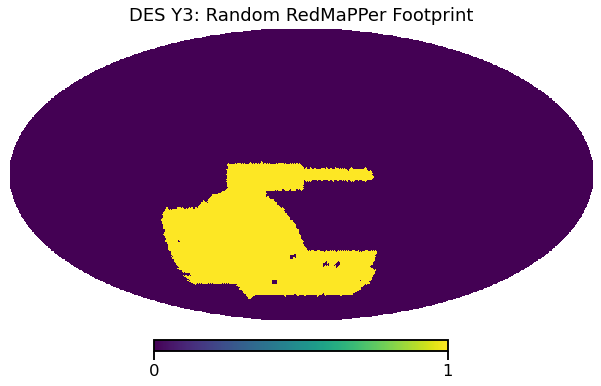

In [13]:
hp.mollview(hpxmap)
plt.title('DES Y3: Random RedMaPPer Footprint')

## JackKnife

In [14]:
class JackKnifer(object):
    """
    Define the masks of the Jackknife giving the mask, number of patches and fraction of the sky you
    want to leave unmasked.
    Args:
        nside_jk (int): HEALPix resolution parameter defining
            the different jackknife regions.
        mask (array): sky mask.
        frac_thr (float): minimum fraction of a given jackknife region
            that must be unmasked for that region to be included in
            the set of regions.
    """
    def __init__(self, nside_jk, mask, frac_thr=0.8):
        # Total number of patches across the sky.
        npatch = hp.nside2npix(nside_jk)
        # Resolution of the maps.
        self.nside_maps = hp.npix2nside(len(mask))
        # Give each JK region an index.
        jk_ids = hp.ud_grade(np.arange(npatch),
                             nside_out=self.nside_maps).astype(int)
        # Number of pixels in each JK region.
        self.npix_per_patch = (self.nside_maps//nside_jk)**2
        ipix = np.arange(hp.nside2npix(self.nside_maps))

        # Loop through available regions and collect only the
        # unmasked ones.
        # match = esutil.numpy_util.match(np.arange(npatch), jk_ids)
        #mask[match[1]] = 
        
        jk_pixels = []
        for ip in range(npatch):
            # Compute masked fraction.
            msk = jk_ids == ip
            frac = np.sum(mask[msk])/self.npix_per_patch
            if frac > frac_thr:  # If above threshold, take.
                jk_pixels.append(ipix[msk])
        self.jk_pixels = np.array(jk_pixels)
        # Total number of JK regions.
        self.npatches = len(self.jk_pixels)

    def get_mask_jk(self, jk_id):
        """
        Get mask associated with a given jackknife region.
        Args:
            jk_id (int): jackknife region index.
        """
        if jk_id >= self.npatches:
            raise ValueError("Asking for non-existent jackknife region")
        # Initially all ones, then zero all pixels in the region.
        msk = np.ones(hp.nside2npix(self.nside_maps))
        msk[self.jk_pixels[jk_id]] = 0
        return msk


In [16]:
nside_jk = 8 #this is the low-resolution nside to define the JK masks. QUanto menor o valor, maior sera sua mascara/menor o numero 
#total de patches a serem removidos
jk =  JackKnifer(nside_jk, hpxmap, frac_thr= 0.5)
npatches = jk.npatches
print('total Jk patches are', npatches)


total Jk patches are 99


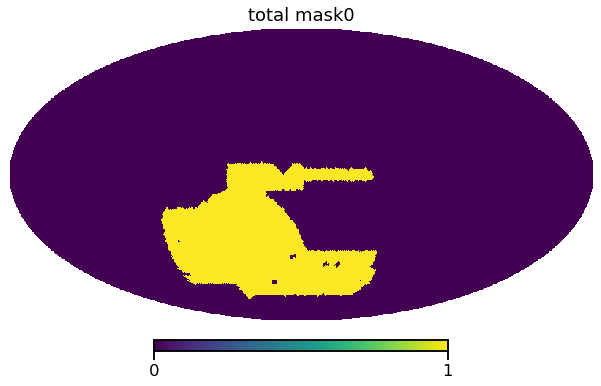

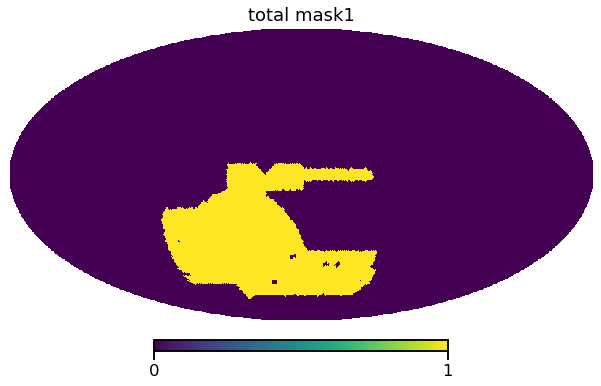

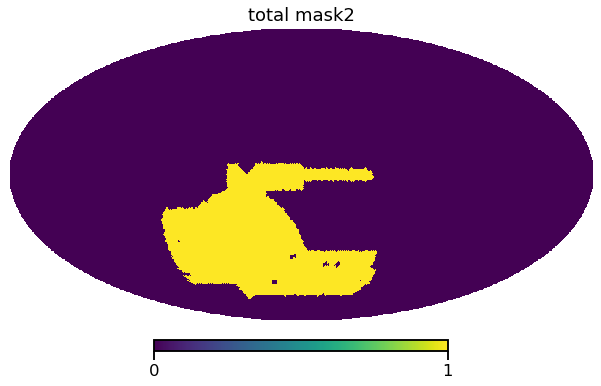

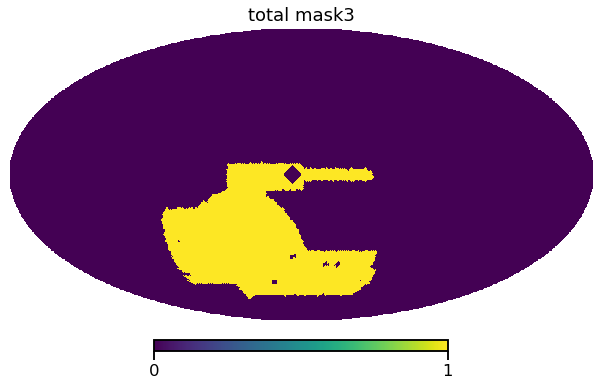

In [18]:
nplots=4
for kk in range(nplots):
    #print(kk)
    jk_mask = jk.get_mask_jk(kk)
    mask_total = hpxmap * (jk_mask)  #usar essa mascara para calcular a funcao de correlacao
    hp.mollview(mask_total)
    plt.title('total mask'+str(kk))

# Count-Count Correlation

In [ ]:
import treecorr

### Run to clusters

In [ ]:
from __future__ import print_function
import pprint

config = treecorr.read_config('config_file.yaml')
print(pprint.pformat(config))

In [ ]:
dd = treecorr.NNCorrelation(config)
# dd.process()

In [ ]:
cat = treecorr.Catalog(ra=rm['ra'], dec=rm['dec'], ra_units='degrees', dec_units='degrees')
rcat = treecorr.Catalog(ra=ran['ra'], dec=ran['dec'], ra_units='degrees', dec_units='degrees')

In [ ]:
dd = treecorr.NNCorrelation(config)
dd.process(cat)

In [ ]:
rr = treecorr.NNCorrelation(config)
rr.process(rcat)

## Plot Results

In [ ]:
xi, varxi = dd.calculateXi(rr)
r = np.exp(dd.meanlogr)
sig = np.sqrt(varxi)

plt.scatter(r, xi, color='blue')
plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='r', lw=3, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='r', lw=3, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonpositive='clip')
plt.xlabel(r'$\theta$ (degrees)')

plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.05,10])
plt.show()

We might want to from 6 arcmin up to 360 arcmin

In [ ]:
# plt.hist(np.abs(sig/xi),bins=np.linspace(0.,0.5,21))

In [ ]:
from astropy.io.fits import getdata

In [ ]:
# hpmap = hp.read_map('y3a2_footprint_griz_1exp_v2.0.fits.gz')
mask = hp.ud_grade(hpmap, nside_out=512)#.astype(int)

In [ ]:
mask[mask==hp.UNSEEN] = 0

In [ ]:
hp.mollview(mask)